$$\Huge{\textbf{Введение}}$$

Работа основана на исследовании студента 181 группы Андреева Никиты Михайловича и представляет из себя набор дополнительных экспериментов на основе его курсовой работы.

В своём исследовании Никита Михайлович реализовал и протестировал новую эффективную модель ($\href{https://github.com/nikich28/ecg}{\text{github}}$) которая выявляет фибрилляцию предсердий с высокой точностью. Однако, задача бинарной классификации предполагалась сбалансированной, что вообще говоря полностью корректно для выявления фибрилляции предсердий у пожилых людей, но может давать менее точные прогнозы для молодых (меньше 40 лет) людей, так как в таком случае процент больных не превосходит нескольких процентов от всей популяции ($\href{https://www.hindawi.com/journals/nri/2015/374352/}{статья}$), а значит, имеет смысл рассмотреть и несбалансированный случай.

В курсовой работе Никиты Михайловича в качестве набора данных используется только датасет $\href{https://physionet.org/content/afdb/1.0.0/}{\text{MIT-BIH Atrial Fibrillation Database}}$. В данной работе так же будут использоваться синтетические данные для имитации несбалансированности данных.

$$\Huge{\textbf{Предварительная обработка данных}}$$

Предварительная обработка данных в нашем случае будет совпадать (почти совпадать*) с подходом Никиты Михайловича. ВЕСЬ код этого раздела взят $\href{https://github.com/nikich28/ecg}{\text{отсюда}}$.

In [378]:
from utils import ecg_processing
import wfdb
import os
import sys
import logging
import pickle
import numpy as np
import pandas as pd
import utils.alphabet as alphabet
from tqdm.auto import tqdm
from IPython.display import clear_output
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, matthews_corrcoef
import utils.ecg_record as ecg_record
import yaml
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

class ECGWindow:

    def __init__(self, peaks_window):
        peaks_window, label = peaks_window
        self.label = label
        self.heart_rate_window =\
            ecg_processing.get_rate_window(peaks_window)
        self.changes_window =\
            ecg_processing.get_changes_window(self.heart_rate_window)

        self.alphabet_encoding = []
        self.ngramms_count = {}
        self.ngramms_idf = {}

        self.mean_hr = self.heart_rate_window.mean()
        self.median_hr = np.median(self.heart_rate_window)
        self.variance_hr = self.heart_rate_window.var()

        self.mean_ch = self.changes_window.mean()
        self.variance_ch = self.changes_window.var()
        self.median_ch = np.median(self.changes_window)
        self.mean_abs_ch = np.mean(np.abs(self.changes_window))
        self.max_ch = np.max(self.changes_window)
        self.min_ch = np.min(self.changes_window)
        self.sum_ch_abs = np.sum(self.changes_window)

    def dict(self):
        dict_ = {"mean_hr": self.mean_hr,
                 "median_hr": self.median_hr,
                 "variance_hr": self.variance_hr,
                 "mean_ch": self.mean_ch,
                 "variance_ch": self.variance_ch,
                 "median_ch": self.median_ch,
                 "mean_abs_ch": self.mean_abs_ch,
                 "max_ch": self.max_ch,
                 "min_ch": self.min_ch,
                 "sum_ch_abs": self.sum_ch_abs,
                 "label": self.label
                }
        if len(self.ngramms_idf) > 0:
            source_ngramms = self.ngramms_idf
        else:
            source_ngramms = self.ngramms_count

        ngramms = {"".join(n_gramm): source_ngramms[n_gramm]
                   for n_gramm in source_ngramms}

        dict_ = {**dict_, **ngramms}

        return dict_

    def prepare_alphabet(self, alphabet_threshold):
        self.alphabet_encoding = alphabet.get_alphabet_encoding(self.changes_window, alphabet_threshold)

    def normalize_ngramms(self, idf):
        norm = 0
        for ngramm in self.ngramms_count:
            self.ngramms_idf[ngramm] =\
                self.ngramms_count[ngramm] * idf[ngramm]
            norm += self.ngramms_idf[ngramm] ** 2
        norm = norm ** 0.5
        for ngramm in self.ngramms_idf:
            self.ngramms_idf[ngramm] /= norm


class ECGRPeaksRecord:

    def __init__(self, name, database):

        self.name = name
        self.database = database
        self.rr_peaks = None
        self.annotation = None
        self.windows = None

    def download(self):
        record = wfdb.rdrecord(f'files/{self.name}', channels=[0])

        self.annotation = wfdb.io.rdann(f'files/{self.name}', extension='atr')

        self.rr_peaks, discarded_count = \
            ecg_processing.get_rr_peaks_indices(record)

    def generate_windows(self, windows_size):
        peaks_windows = ecg_processing.produce_peaks_windows(
            self.rr_peaks,
            windows_size,
            self.annotation
        )
        windows = [ECGWindow(p) for p in peaks_windows]
        return windows, peaks_windows


def download_database(
        data_folder,
        database='afdb',
        ):
    records = [ECGRPeaksRecord(r, database)
               for r in wfdb.get_record_list(database)]
    logging.info("saving records")
    for r in tqdm(records):
        try:
            r.download()
        except Exception:
            exc_type, _, traceback = sys.exc_info()
            logging.info("failed to download record:{};\n"
                         "Exception:{}\nTraceback:{}\n\n".
                         format(r.name, exc_type, traceback)
                         )
            continue
        path_to_record = os.path.join(data_folder, r.name)
        with open(path_to_record, "wb") as f:
            pickle.dump(r, f)


def restore_records(data_folder):
    files = os.listdir(data_folder)
    files = [os.path.join(data_folder, f) for f in files]
    records = []
    for fpath in tqdm(files):
        with open(fpath, 'rb') as f:
            records.append(pickle.load(f))

    return records


def build_windows_dataset(records_folder, windows_size):
    records = restore_records(records_folder)
    windows = dict()
    data_ = []
    for record in tqdm(records):
        a, b = record.generate_windows(windows_size)
        windows[record.name] = a
        data_ += b
        #print("Record number:", record.name, "end of the record:", len(data_))
    new_data = []
    for d in tqdm(data_):
        new_data.append(d[0] + [d[1]])
    new_data = pd.DataFrame(new_data)
    new_data.to_csv("C:/Users/alexm/Desktop/new_data1")
    return windows

In [4]:
download_database('files')

  0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
windows = build_windows_dataset('files/tmp', 32)
clear_output()

In [92]:
df = pd.read_csv('new_data1')
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,0,0.772,1.408,2.344,2.892,3.500,4.452,5.012,5.640,6.580,...,16.608,17.568,18.124,18.772,19.704,20.576,21.424,22.284,23.140,0
1,1,1.408,2.344,2.892,3.500,4.452,5.012,5.640,6.580,7.424,...,17.568,18.124,18.772,19.704,20.576,21.424,22.284,23.140,23.976,0
2,2,2.344,2.892,3.500,4.452,5.012,5.640,6.580,7.424,8.264,...,18.124,18.772,19.704,20.576,21.424,22.284,23.140,23.976,24.508,0
3,3,2.892,3.500,4.452,5.012,5.640,6.580,7.424,8.264,9.104,...,18.772,19.704,20.576,21.424,22.284,23.140,23.976,24.508,25.064,0
4,4,3.500,4.452,5.012,5.640,6.580,7.424,8.264,9.104,9.932,...,19.704,20.576,21.424,22.284,23.140,23.976,24.508,25.064,25.556,0


In [356]:
def windows_to_dataframe(windows_dataset,
                         records_set):
    record_to_ind = {}
    dataset = []
    windows_count = 0
    for record in tqdm(records_set):
        record_to_ind[record] = []
        for window in windows_dataset[record]:
            dataset.append(window.dict())
            record_to_ind[record].append(windows_count)
            windows_count += 1
    dataset = pd.DataFrame(dataset)
    dataset.to_csv("C:/Users/alexm/Desktop/dataset32")
    return dataset, record_to_ind

In [357]:
for record in tqdm(windows):
    clear_output()
    for window in tqdm(windows[record]):
        window.prepare_alphabet(0.3)

  0%|          | 0/61123 [00:00<?, ?it/s]

In [358]:
dataset, record_to_ind = windows_to_dataframe(windows, train_records)

  0%|          | 0/23 [00:00<?, ?it/s]

In [359]:
dataset

,mean_hr,median_hr,variance_hr,mean_ch,variance_ch,median_ch,mean_abs_ch,max_ch,min_ch,sum_ch_abs,label,AA,AB,AC,BA,BB,BC,CA,CB,CC
0,0.721548,0.824,0.030619,0.055419,0.099190,-0.002326,0.222344,0.923729,-0.420833,1.662562,0,0.016968,0.456441,0.226467,0.212559,0.000000,0.436932,0.709926,0.000000,0.0
1,0.728000,0.828,0.030763,0.038917,0.093349,-0.004695,0.207399,0.923729,-0.420833,1.167500,0,0.019577,0.482744,0.239518,0.224808,0.000000,0.308075,0.750838,0.000000,0.0
2,0.714968,0.824,0.030437,0.040613,0.091894,-0.004695,0.205703,0.923729,-0.420833,1.218393,0,0.021004,0.517926,0.385461,0.241192,0.000000,0.330527,0.644446,0.000000,0.0
3,0.715226,0.824,0.030353,0.038467,0.091732,-0.004695,0.203557,0.923729,-0.420833,1.154017,0,0.019698,0.388570,0.361486,0.226190,0.000000,0.309969,0.755454,0.000000,0.0
4,0.711484,0.824,0.031575,0.015771,0.082734,-0.004785,0.188534,0.923729,-0.420833,0.473120,0,0.022151,0.403361,0.375246,0.234800,0.000000,0.160884,0.784210,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149515,0.513161,0.464,0.063197,0.702270,6.345932,0.013258,1.119564,13.142857,-0.926316,21.068097,1,0.004980,0.147352,0.548326,0.343100,0.298445,0.235090,0.229184,0.602512,0.0
1149516,0.520774,0.464,0.068268,0.711204,6.338627,0.013258,1.128498,13.142857,-0.926316,21.336115,1,0.005149,0.228549,0.472485,0.354774,0.308600,0.243089,0.236982,0.623013,0.0
1149517,0.500903,0.452,0.066950,0.701803,6.363477,0.013258,1.137898,13.142857,-0.926316,21.054095,1,0.005069,0.225005,0.465160,0.349274,0.303815,0.358981,0.116654,0.613353,0.0
1149518,0.501806,0.464,0.066879,0.744630,6.333612,0.088622,1.162868,13.142857,-0.926316,22.338901,1,0.004929,0.218755,0.361791,0.339572,0.295377,0.349009,0.113414,0.695703,0.0


Итак, мы получили датасет, с которым работал Никита Михайлович. Но как мы видим, в нём действительно не наблюдается проблемы несбалансированности классов:

In [360]:
print(dataset['label'].sum() / dataset.shape[0])

0.44600354930753705


Для демонстрации ограничимся искусственным изменением баланса классов в имеющемся датасете путём простого уменьшения количества объектов с меткой 1. **Следует отметить, что такой подход исказит результат, для серьёзного исследования НЕОБХОДИМ более точный подход.**

In [361]:
def windows_to_imbalanced_dataframe(windows_dataset,
                         records_set):
    record_to_ind = {}
    dataset = []
    windows_count = 0
    counter = 0
    for record in tqdm(records_set):
        record_to_ind[record] = []
        for window in windows_dataset[record]:
            if window.label == 0 or counter == 0:
                dataset.append(window.dict())
                record_to_ind[record].append(windows_count)
                windows_count += 1
            counter += 1
            counter %= 50
    dataset = pd.DataFrame(dataset)
    dataset.to_csv("C:/Users/alexm/Desktop/imbalanced_dataset32")
    return dataset, record_to_ind

In [362]:
for record in tqdm(windows):
    clear_output()
    for window in tqdm(windows[record]):
        window.prepare_alphabet(0.3)

  0%|          | 0/61123 [00:00<?, ?it/s]

In [363]:
alphabet.build_alphabet_dataset(windows, 2)
key = (0.3, 2)

In [364]:
train_records = windows.keys()
train_records

dict_keys(['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434', '08455'])

In [365]:
imbalanced_dataset, record_to_ind = windows_to_imbalanced_dataframe(windows, train_records)

  0%|          | 0/23 [00:00<?, ?it/s]

In [366]:
imbalanced_dataset

,mean_hr,median_hr,variance_hr,mean_ch,variance_ch,median_ch,mean_abs_ch,max_ch,min_ch,sum_ch_abs,label,AA,AB,AC,BA,BB,BC,CA,CB,CC
0,0.721548,0.824,0.030619,0.055419,0.099190,-0.002326,0.222344,0.923729,-0.420833,1.662562,0,0.016968,0.456441,0.226467,0.212559,0.000000,0.436932,0.709926,0.000000,0.000000
1,0.728000,0.828,0.030763,0.038917,0.093349,-0.004695,0.207399,0.923729,-0.420833,1.167500,0,0.019577,0.482744,0.239518,0.224808,0.000000,0.308075,0.750838,0.000000,0.000000
2,0.714968,0.824,0.030437,0.040613,0.091894,-0.004695,0.205703,0.923729,-0.420833,1.218393,0,0.021004,0.517926,0.385461,0.241192,0.000000,0.330527,0.644446,0.000000,0.000000
3,0.715226,0.824,0.030353,0.038467,0.091732,-0.004695,0.203557,0.923729,-0.420833,1.154017,0,0.019698,0.388570,0.361486,0.226190,0.000000,0.309969,0.755454,0.000000,0.000000
4,0.711484,0.824,0.031575,0.015771,0.082734,-0.004785,0.188534,0.923729,-0.420833,0.473120,0,0.022151,0.403361,0.375246,0.234800,0.000000,0.160884,0.784210,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647080,0.452774,0.416,0.036201,0.201910,0.532555,0.077526,0.550593,2.134615,-0.866667,6.057312,1,0.010075,0.223585,0.184890,0.231380,0.603797,0.475621,0.115918,0.507902,0.000000
647081,0.892903,0.504,3.955015,0.771551,5.053565,0.041485,1.276490,10.624000,-0.859813,23.146531,1,0.001553,0.091887,0.113976,0.142635,0.558321,0.439799,0.071458,0.438339,0.505792
647082,0.530581,0.528,0.031410,0.175579,0.571055,-0.003759,0.518742,2.313725,-0.613636,5.267357,1,0.010608,0.078476,0.486706,0.365452,0.000000,0.250406,0.000000,0.748724,0.000000
647083,0.544774,0.476,0.042256,0.125149,0.273248,0.008154,0.425916,1.411111,-0.701493,3.754472,1,0.006530,0.386457,0.159787,0.349939,0.782727,0.102761,0.100180,0.263366,0.000000


Теперь мы имеем дело с несбалансированным датасетом (процент больных близок к показателю среди молодого населения).

In [367]:
print(imbalanced_dataset['label'].sum() / imbalanced_dataset.shape[0])

0.015847995240192557


$$\Huge{\textbf{Метрики качества}}$$

В работе Никита Михайлович использовал метрики `Sensitivity`, `Specificity` и `AUC-PR`. Мы будем использовать их и коэффициент корреляции Мэтьюза. Он выражается в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - уровень случайного предсказания, -1 - полная несогласованность. Метрика является симметричной и не различает "верные" и "предсказанные" метки.

$$\Huge{\textbf{Обучение}}$$

Код всё так же взят $\href{https://github.com/nikich28/ecg}{\text{отсюда}}$.

In [373]:
def windows_cv_iter(rec_to_ind, n_folds, train_folds):
    #records_list = list(rec_to_ind.keys())
    a, b, c, d = train_folds
    records_split_ind_iter = [[a + b + c, d],
                              [a + b + d, c],
                              [a + c + d, b],
                              [b + c + d, a]]

    for split_indices in tqdm(records_split_ind_iter):

        #train_records = [records_list[ind] for ind in split_indices[0]]
        #test_records = [records_list[ind] for ind in split_indices[1]]
        train_records = split_indices[0]
        test_records = split_indices[1]

        test_windows_indices = []
        train_windows_indices = []
        for r in train_records:
            train_windows_indices += rec_to_ind[r]

        for r in test_records:
            test_windows_indices += rec_to_ind[r]

        yield test_windows_indices, train_windows_indices



def evaluate_estmator(estimator, x, y, test_fold, rec_to_ind):
    test_windows_indices = []
    for r in test_fold:
        test_windows_indices += rec_to_ind[r]

    prediction = estimator.predict(x[test_windows_indices])
    prediction_proba = estimator.predict_proba(x[test_windows_indices])
    #for svm should use the next line and change for auc
    #prediction_proba = estimator.decision_function(x[test_windows_indices])

    metrics = dict()

    metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),
                                   prediction_proba[:, 1])
    #metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),
    #                               prediction_proba)

    metrics["sensitivity"] = recall_score(prediction, y[test_windows_indices], pos_label=1)
    metrics["accuracy"] = accuracy_score(prediction, y[test_windows_indices])
    metrics["specificity"] = recall_score(prediction, y[test_windows_indices], pos_label=0)
    metrics["MCC"] = matthews_corrcoef(prediction, y[test_windows_indices])

    return metrics


def cv_search(dataset,
              record_to_ind,
              estimator,
              estimator_params_grid,
              n_folds,
              n_jobs=-1):

    x, y = dataframe_to_numpy(dataset)

    a = ['04015', '04126', '04936', '07879', '08405']
    b = ['04043', '04048', '07859', '07910']
    c = ['04746', '05261', '08215', '08378', '08455']
    d = ['04908', '06426', '07162', '08219', '08434']
    e = ['05091', '05121', '06453', '06995']
    folds = [a, b, c, d, e]
    results = dict()
    params = dict()
    for f in tqdm(range(n_folds)):
        test_fold = folds[f]
        train_folds = [folds[f-1], folds[f-2], folds[f-3], folds[f-4]]

        record_cv_splitter = windows_cv_iter(
            record_to_ind, n_folds, train_folds)

        random_search = GridSearchCV(
            estimator,
            param_grid=estimator_params_grid,
            n_jobs=n_jobs,
            scoring='roc_auc',
            cv=record_cv_splitter,
            verbose=3,
            refit=True
        )

        random_search.fit(x, y)

        test_scores = evaluate_estmator(random_search, x, y, test_fold, record_to_ind)
        results['fold' + str(f)] = test_scores
        params['fold' + str(f)] = random_search.best_estimator_

    return params, results

In [374]:
with open(r'params.yml') as file:
    params_list = yaml.load(file, Loader=yaml.FullLoader)
est_params = params_list["est_params"]

In [375]:
params, results = cv_search(
    imbalanced_dataset,
    record_to_ind,
    XGBClassifier(),
    est_params,
    5
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


In [377]:
results

{'fold0': {'auc': 0.9999116507269667,
  'sensitivity': 0.9964871194379391,
  'accuracy': 0.9990727896619698,
  'specificity': 0.9991220760669007,
  'MCC': 0.9754784685391004},
 'fold1': {'auc': 0.9999493930044322,
  'sensitivity': 0.9939831528279182,
  'accuracy': 0.9991288522412648,
  'specificity': 0.9992036892813076,
  'MCC': 0.9701787163633999},
 'fold2': {'auc': 0.9999798807779932,
  'sensitivity': 0.9995824634655532,
  'accuracy': 0.9993329239912371,
  'specificity': 0.999328309811309,
  'MCC': 0.9817712289117317},
 'fold3': {'auc': 0.999818740914912,
  'sensitivity': 0.984375,
  'accuracy': 0.9991924311303876,
  'specificity': 0.9993999590560297,
  'MCC': 0.9708391934509137},
 'fold4': {'auc': 0.9997104461017013,
  'sensitivity': 0.9887096774193549,
  'accuracy': 0.9990726377554462,
  'specificity': 0.9991821155943293,
  'MCC': 0.957097642923624}}

$$\Huge{\textbf{Борьба с имбалансом + эксперименты}}$$

Несмотря на то, что качество на искуственно (и наивно) разбалансированном датасете едва отличается от качества на исходном, попробуем проверить несколько основных техник борьбы с имбалансом. В частности рассмотрим методы оверсэмплинга. Этот подход на первый взгляд кажется наиболее разумным, так как фактически позволяет свести несбалансированную задачу бинарной классификации записей ЭКГ молодых людей к уже эффективно решённой задачи классификации. Идея оверсэмплинга заключается в дублировании объектов минорного класса. Есть различные подходы к оверсэмплингу, мы в частности рассмотрим классический `SMOTE` и `ADASYN`. Оба метода реализованы в библиотеке `imblearn`.

In [382]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

Суть метода `SMOTE` заключается в следующем: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, и добавляем в выборку выпуклую комбинацию со случайными коэффициентами.

In [386]:
def smote_cv_search(dataset,
              record_to_ind,
              estimator,
              estimator_params_grid,
              n_folds,
              n_jobs=-1):

    x, y = dataframe_to_numpy(dataset)

    a = ['04015', '04126', '04936', '07879', '08405']
    b = ['04043', '04048', '07859', '07910']
    c = ['04746', '05261', '08215', '08378', '08455']
    d = ['04908', '06426', '07162', '08219', '08434']
    e = ['05091', '05121', '06453', '06995']
    folds = [a, b, c, d, e]
    results = dict()
    params = dict()
    for f in tqdm(range(n_folds)):
        test_fold = folds[f]
        train_folds = [folds[f-1], folds[f-2], folds[f-3], folds[f-4]]

        record_cv_splitter = windows_cv_iter(
            record_to_ind, n_folds, train_folds)

        random_search = GridSearchCV(
            estimator,
            param_grid=estimator_params_grid,
            n_jobs=n_jobs,
            scoring='roc_auc',
            cv=record_cv_splitter,
            verbose=3,
            refit=True
        )

        sm = SMOTE(sampling_strategy=0.1, random_state=42)
        X_train_resampled, y_train_resampled = sm.fit_resample(x, y)

        sm_model = random_search.fit(X_train_resampled, y_train_resampled)

        test_scores = evaluate_estmator(random_search, x, y, test_fold, record_to_ind)
        results['fold' + str(f)] = test_scores
        params['fold' + str(f)] = random_search.best_estimator_

    return params, results

In [387]:
sm_params, sm_results = smote_cv_search(
    imbalanced_dataset,
    record_to_ind,
    XGBClassifier(),
    est_params,
    5
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


In [390]:
sm_results

{'fold0': {'auc': 0.9997325491431193,
  'sensitivity': 0.9639909977494373,
  'accuracy': 0.9985617288457327,
  'specificity': 0.9992479747438646,
  'MCC': 0.9623548925977937},
 'fold1': {'auc': 0.9998747159090168,
  'sensitivity': 0.9571428571428572,
  'accuracy': 0.9987665927772363,
  'specificity': 0.9994044960547863,
  'MCC': 0.9584368298483172},
 'fold2': {'auc': 0.9999349091320834,
  'sensitivity': 0.9865470852017937,
  'accuracy': 0.9992874415360942,
  'specificity': 0.9995288338250969,
  'MCC': 0.9806018610665751},
 'fold3': {'auc': 0.9996539725290524,
  'sensitivity': 0.8952380952380953,
  'accuracy': 0.9979462688229683,
  'specificity': 0.9995474985152295,
  'MCC': 0.9301756058416515},
 'fold4': {'auc': 0.9996510249649516,
  'sensitivity': 0.8788732394366198,
  'accuracy': 0.9979260807985432,
  'specificity': 0.9993685791323936,
  'MCC': 0.9098316772020417}}

В методе `ADASYN` используется взвешенное распределение для разных объектов минорного класса (в зависимости от уровня трудности обучения объекта) и 'дублируются' (=генерируются похожие) больше именно те объекты минорного класса, которые представляют бОльшую сложность.

In [391]:
def ada_cv_search(dataset,
              record_to_ind,
              estimator,
              estimator_params_grid,
              n_folds,
              n_jobs=-1):

    x, y = dataframe_to_numpy(dataset)

    a = ['04015', '04126', '04936', '07879', '08405']
    b = ['04043', '04048', '07859', '07910']
    c = ['04746', '05261', '08215', '08378', '08455']
    d = ['04908', '06426', '07162', '08219', '08434']
    e = ['05091', '05121', '06453', '06995']
    folds = [a, b, c, d, e]
    results = dict()
    params = dict()
    for f in tqdm(range(n_folds)):
        test_fold = folds[f]
        train_folds = [folds[f-1], folds[f-2], folds[f-3], folds[f-4]]

        record_cv_splitter = windows_cv_iter(
            record_to_ind, n_folds, train_folds)

        random_search = GridSearchCV(
            estimator,
            param_grid=estimator_params_grid,
            n_jobs=n_jobs,
            scoring='roc_auc',
            cv=record_cv_splitter,
            verbose=3,
            refit=True
        )
        
        ada = ADASYN(random_state=42)
        X_train_resampled, y_train_resampled = ada.fit_resample(x, y)

        ada_model = random_search.fit(X_train_resampled, y_train_resampled)

        test_scores = evaluate_estmator(ada_model, x, y, test_fold, record_to_ind)
        results['fold' + str(f)] = test_scores
        params['fold' + str(f)] = random_search.best_estimator_

    return params, results

In [392]:
ada_params, ada_results = ada_cv_search(
    imbalanced_dataset,
    record_to_ind,
    XGBClassifier(),
    est_params,
    5
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 4 folds for each of 1 candidates, totalling 4 fits


<ipython-input-373-333764cce4b2>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics['auc'] = roc_auc_score(np.array(y[test_windows_indices], dtype=np.int),


In [393]:
ada_results

{'fold0': {'auc': 0.9994820254850854,
  'sensitivity': 0.7257488320967299,
  'accuracy': 0.9924947068701175,
  'specificity': 0.9997749960624311,
  'MCC': 0.843791105147861},
 'fold1': {'auc': 0.9997051550929327,
  'sensitivity': 0.8548548548548549,
  'accuracy': 0.9971968017664461,
  'specificity': 0.9996928234788179,
  'MCC': 0.9139026031928364},
 'fold2': {'auc': 0.9998667634805748,
  'sensitivity': 0.8750444998220007,
  'accuracy': 0.9971649269627575,
  'specificity': 0.9998218573309581,
  'MCC': 0.9297222985079456},
 'fold3': {'auc': 0.9992176256474332,
  'sensitivity': 0.6637988087359364,
  'accuracy': 0.9927040329710877,
  'specificity': 0.9997724347349931,
  'MCC': 0.8052272669162973},
 'fold4': {'auc': 0.9990418648026874,
  'sensitivity': 0.5838255338482508,
  'accuracy': 0.9919656707358198,
  'specificity': 0.999682171541468,
  'MCC': 0.7500797861626566}}

В библиотеке `imblearn` представлены и другие методы, заслуживающие внимания. Например, `SVM-SMOTE`, в котором пограничные объекты минорного класса генерируются вдоль разделяющей гиперплоскости (=границы между мажорным и минорным классами), которая строится SVM-классификатором, обученном на оригинальной обучающей выборке. Но наибольший интерес, согласно результатам Никиты Михайловича, представляла бы модификация `SMOTE`, основанная на бустинге. К сожалению, `SVM-Boost` на данный момент не реализован, поэтому в данный работе он не будет рассматриваться. Посмотрим сравнение эффективности оригинального алгоритма и оверсэмплинга на синтетически несбалансированном датасете:

In [424]:
plt.rcParams['figure.figsize'] = (15, 10)
methods = [results, sm_results, ada_results]
range_axis = [int(i) for i in range(5)]
folds = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4']
metrics = ['auc', 'sensitivity', 'accuracy', 'specificity', 'MCC']
colors = ['DarkOrchid', 'LimeGreen', 'Turquoise', 'Red', 'Blue']
titles = ['оригинальной модели', 'SMOTE', 'ADASYN']

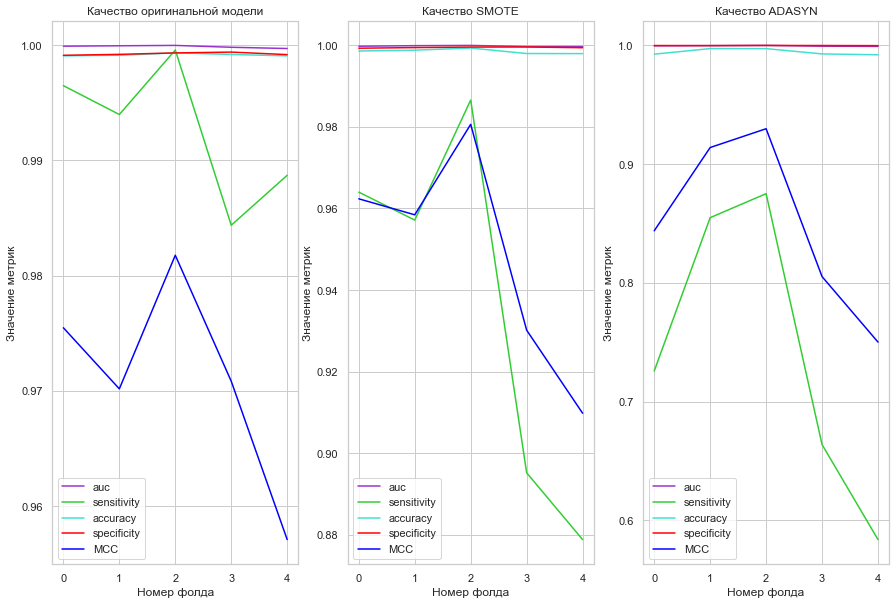

In [425]:
for i in range(3):
    plt.subplot(1, 3, i + 1)
    for j in range(5):
        plt.plot(range_axis, [methods[i][folds[k]][metrics[j]] for k in range(5)], color=colors[j], label=metrics[j])

    plt.title('Качество ' + titles[i])
    plt.xlabel('Номер фолда')
    plt.ylabel('Значение метрик')

    plt.legend()

По графикам видно, что значения метрик `auc`, `accuracy` и `specificity` почти не различаются между моделями. Однако, в моделях с оверсэмплингом значение `sensitivity` ниже, чем в оригинальной, что в совокупности означает бОльший разрыв между метриками `sensitivity` и `specificity` в моделях с оверсэмплингом. Это плохой результат в рамках задачи несбалансированной классификации. Особенно велик разрыв между этими двумя метриками в методе `ADASYN`. Аналогично, сильно отстаёт и значение метрики `MCC` в моделе `ADASYN`. Модель `SMOTE` показала себя хуже оригинальной модели, но в целом с ней сопоставима, что наводит на мысли о том, что это может быть результатом неточной имитации несбалансированного датасета.

$$\Huge{\textbf{Выводы}}$$

Требуется проведение дополнительных экспериментов. В частности, план дальнейших действий примерно таков:

1) Необходимо сгенерировать наиболее реалистичный несбалансированный синтетический датасет. Методы моделирования ЭКГ сигналов существуют.

2) Есть смысл реализовать модель `SMOTEBoost` и эксперементировать с ней.

3) Возможно, есть смысл проверить ещё несколько моделей, например, основанные на методе опорных векторов или адабусте.

Ниже приведены написанные мной шаблоны функций для обучения новых классификаторов (модифицированный код Никиты Михайловича, чтобы работали кастомные методы ресамплинга)

In [427]:
# a function to fit an estimator

def custom_cv_search(dataset,
              record_to_ind,
              estimator,
              estimator_params_grid,
              n_folds,
              resampler=None,
              resample_kwargs=None,
              resample=False,
              n_jobs=-1):
    
    #dataset - windows_to_dataframe output
    #record_to_ind - windows_to_dataframe output
    #estimator - custom estimator to fit
    #estimator_params_grid
    #resample - whether a resampling method is used (defaulf False)
    #resampler (str) - name of a resampling method
    #resample_kwargs - argsdict for a resampling method

    x, y = dataframe_to_numpy(dataset)

    a = ['04015', '04126', '04936', '07879', '08405']
    b = ['04043', '04048', '07859', '07910']
    c = ['04746', '05261', '08215', '08378', '08455']
    d = ['04908', '06426', '07162', '08219', '08434']
    e = ['05091', '05121', '06453', '06995']
    folds = [a, b, c, d, e]
    results = dict()
    params = dict()
    for f in tqdm(range(n_folds)):
        test_fold = folds[f]
        train_folds = [folds[f-1], folds[f-2], folds[f-3], folds[f-4]]

        record_cv_splitter = windows_cv_iter(
            record_to_ind, n_folds, train_folds)

        random_search = GridSearchCV(
            estimator,
            param_grid=estimator_params_grid,
            n_jobs=n_jobs,
            scoring='roc_auc',
            cv=record_cv_splitter,
            verbose=3,
            refit=True
        )
        
        if resample or resampler is not None:
            resampling = globals()[resampler](**resample_kwargs)
            x_train_resampled, y_train_resampled = resampling.fit_resample(x, y)
            resampled_model = random_search.fit(x_train_resampled, y_train_resampled)
            test_scores = evaluate_estmator(resampled_model, x, y, test_fold, record_to_ind)
        else:
            random_search.fit(x, y)
            test_scores = evaluate_estmator(random_search, x, y, test_fold, record_to_ind)

        results['fold' + str(f)] = test_scores
        params['fold' + str(f)] = random_search.best_estimator_

    return params, results